In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [3]:
exp_ids=['2018_06_22_17_02_17_Open loop Ramsey, ac stark beam between, aom 157.6 MHz'
]

In [4]:
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_22/2018_06_22_17_02_17_Open loop Ramsey, ac stark beam between, aom 157.6 MHz/qdp.txt


# Experiment-wise analysis

2018_06_22_17_02_17_Open loop Ramsey, ac stark beam between, aom 157.6 MHz
0


<IPython.core.display.Javascript object>


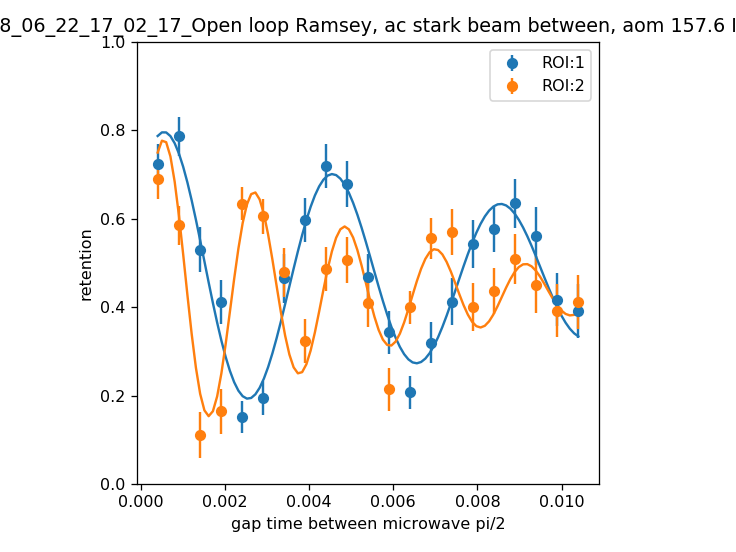

[0.017, 0.30440286428217728, 350, 1.5707963267948966, 0.48248238161946205]
tau 1  is  0.0116511542881  with 1 std of   0.00314611636387
amplitude 1  is  -0.343973541262  with 1 std of   0.0372364333938
frequency 1  is  249.946019599  with 1 std of   4.23557754343
phase 1  is  3.7941025302  with 1 std of   0.132370859247
offset 1  is  0.468747768335  with 1 std of   0.0114535533697
[0.017, 0.24559566653861087, 350, 1.5707963267948966, 0.44454517853181164]
tau 2  is  0.00512291692018  with 1 std of   0.00137788688844
amplitude 2  is  0.384677949403  with 1 std of   0.0662439800542
frequency 2  is  464.809757681  with 1 std of   9.0814219409
phase 2  is  -0.0728989780201  with 1 std of   0.197166118529
offset 2  is  0.433431333013  with 1 std of   0.0152417894446


In [5]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=[ '#ff7f0e','#1f77b4','#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.006, 0.43, 409 ,1.107, 0.47]
    fit_guesses2=[  0.522, 0.411, 190 ,1.52, 0.5]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        offsetguess = np.mean(reten)
        Ampguess = np.max(reten)-offsetguess
        fit_guesses = [0.017,Ampguess , 350 ,np.pi/2, offsetguess]   
        print fit_guesses
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
       # yfit2=decaying_sin(xarray, 0.522, 0.411, 190 ,1.52, 0.5)
        plt.plot(xarray,yfit,color=colors[roi])
       # plt.plot(xarray,yfit2,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(0.5*int(assorted['timestamps'][i][0]+assorted['timestamps'][i][-1])).strftime('%Y-%m-%d %H:%M:%S')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



<IPython.core.display.Javascript object>


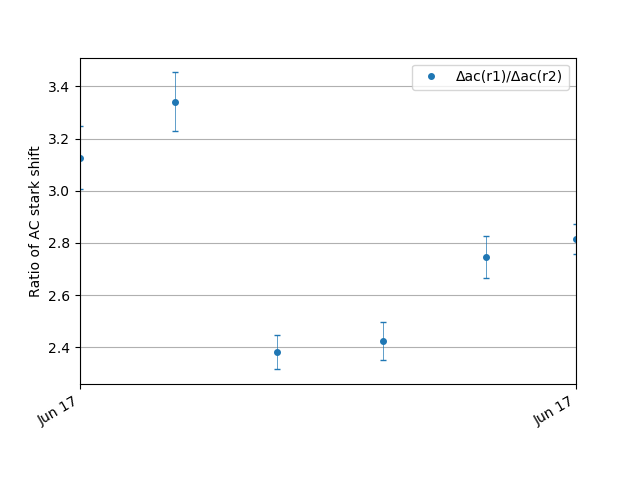

<IPython.core.display.Javascript object>


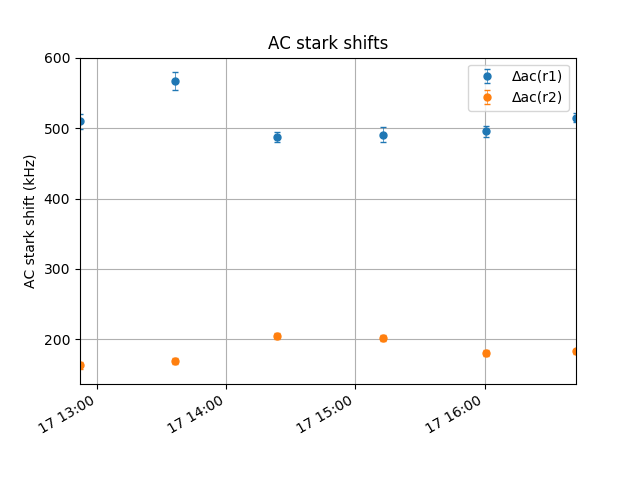

In [9]:
savefig=False
ratio_data=[]
ratio_error=[]
# avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]
# endtime=[]
# endtime_in_UNIX=[]
middletime=[]
# middletime_in_UNIX=[]

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ROI1_ac.append(data11[i][2])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    ratio_error.append(error_total)
    middletime.append(dt.datetime.fromtimestamp(0.5*int(assorted['timestamps'][i][0]+assorted['timestamps'][i][-1])))

# Plotting by clock time
df=pd.DataFrame({ "Δac(r1)/Δac(r2)": ratio_data,'error': ratio_error
                 ,"Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac, 'ROI1_err': ROI1_err, 'ROI2_err': ROI2_err
                 ,"middletime":middletime, "startingtime":startingtime
                },index=middletime)
ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
#ax.set_xlim(dt.datetime(2018,5,22))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

# AC stark shifts
ax=df.plot(y=["Δac(r1)"],yerr='ROI1_err',capsize=2,alpha=1,lw=0.5,marker='o',markersize=5,linestyle='None')
df.plot(y=["Δac(r2)"],yerr='ROI2_err',capsize=2,alpha=1,lw=0.5,marker='o',markersize=5,linestyle='None',ax=ax)
hours=md.HourLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shifts')
ax.legend()


<IPython.core.display.Javascript object>


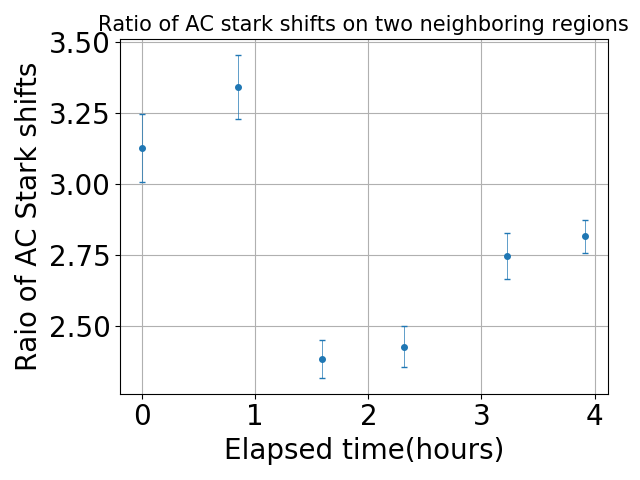

In [10]:
# Plotting by Time difference

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
#fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

In [11]:
peakshift=825 # kHz
wx=8.1 # um
spacing = 9.25 # um

def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res

ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    print "doing {}-th fit.. out of {}".format(z,len(ratio_error))
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

doing 0-th fit.. out of 6
doing 1-th fit.. out of 6
doing 2-th fit.. out of 6
doing 3-th fit.. out of 6
doing 4-th fit.. out of 6
doing 5-th fit.. out of 6


<IPython.core.display.Javascript object>


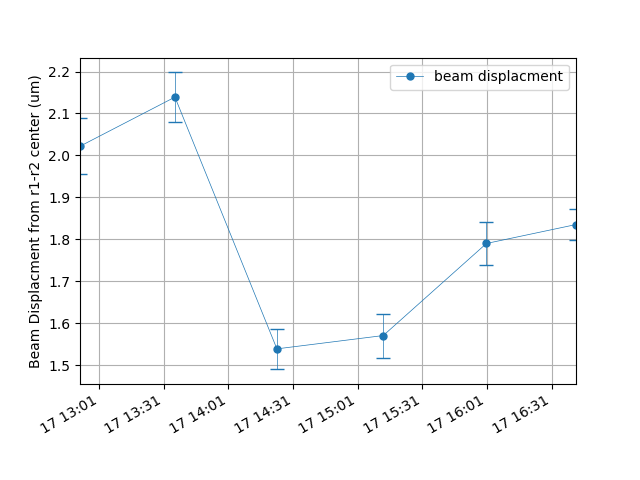

<IPython.core.display.Javascript object>


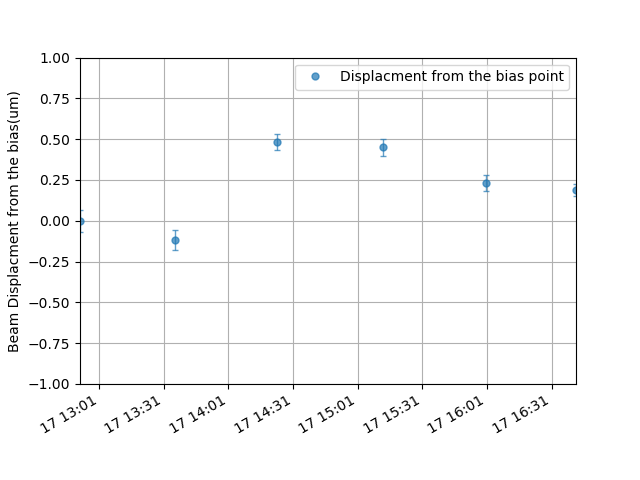

In [12]:
bias_point=np.array(ratio_to_dist[0])
displacement_frombias=ratio_to_dist-bias_point
df_displacement=pd.DataFrame({ "beam displacment": ratio_to_dist,"Displacment from the bias point":-displacement_frombias,'Max_error': dist_max_error,'Min_error': dist_min_error}
                             ,index=middletime)
ax=df_displacement.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
#ax.set_xlim(dt.datetime(2018,6,17,12),dt.datetime(2018,6,18,13,0))
ax.grid()
ax=df_displacement.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_ylim(-1,1)
ax.grid()

<IPython.core.display.Javascript object>


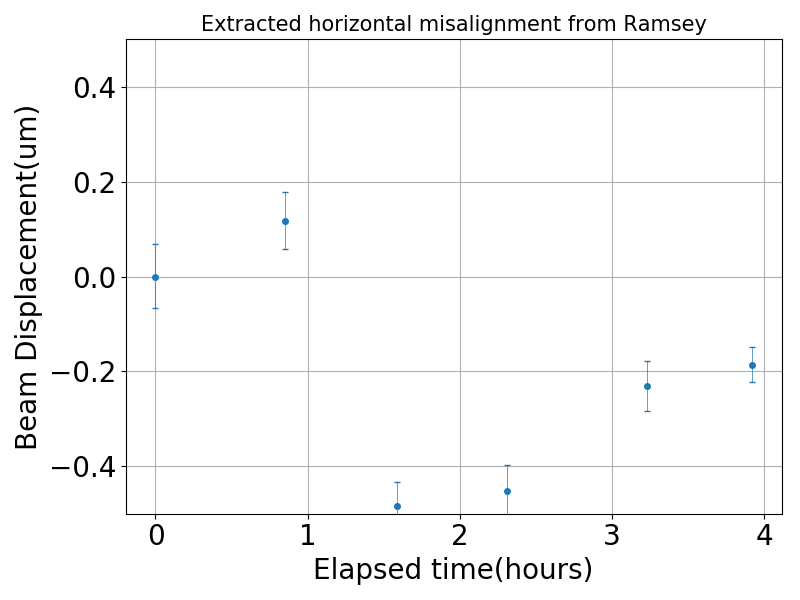

In [13]:
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Beam Displacement(um)',fontsize=20)
ax.set_title('Extracted horizontal misalignment from Ramsey',fontsize=15)
ax.set_ylim(-0.5,0.5)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Extracted_horizontal_misalignment_from_Ramsey'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')

# TIME SERIES ANALYSES

In [14]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

actuator_variables=['Red_X','Red_Y']

# exp_ids : This is list for Ramsey experiments.
# There are more experients with AAS on. Add them in this list
AAS_ids=[
        ]

entire_closed_ids=exp_ids+AAS_ids


data={}
for j in range(0,len(entire_closed_ids)):
    exp_id=entire_closed_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

        for var in actuator_variables:
            if i==0 and j==0:
                data[var]=[]
            try:
                data[var].append(q.experiments[e]['iterations'][i]['variables'][var])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, var)
                

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_12_27_34_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_13_18_34_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_14_02_42_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_14_46_09_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_15_41_15_Open loop Ramsey, temperature controlled box/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_17/2018_06_17_16_22_40_Open loop Ramsey, temperature controlled box/

<IPython.core.display.Javascript object>


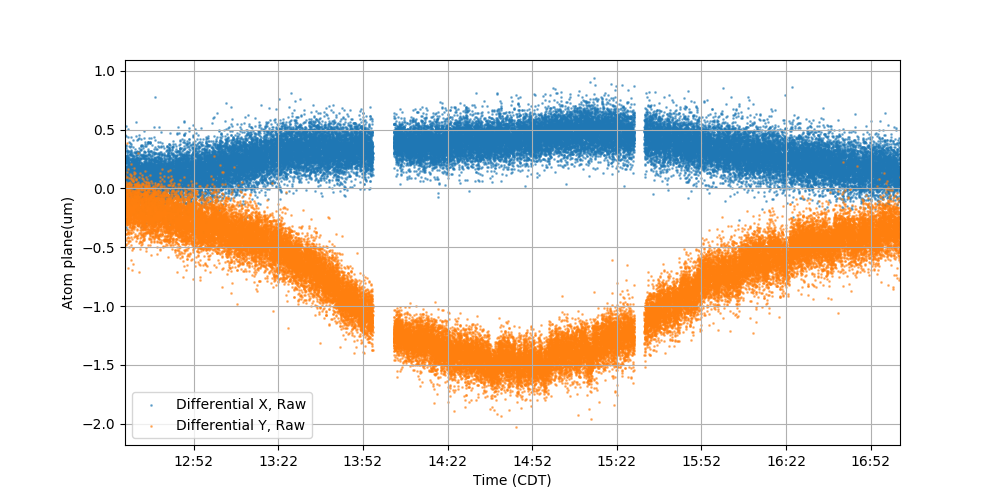

In [15]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
experiment_start_time=flattendedtimestamps[0]
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=1,alpha=0.5,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])
#ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=1,alpha=0.5,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

# Insert room temperature history

<IPython.core.display.Javascript object>


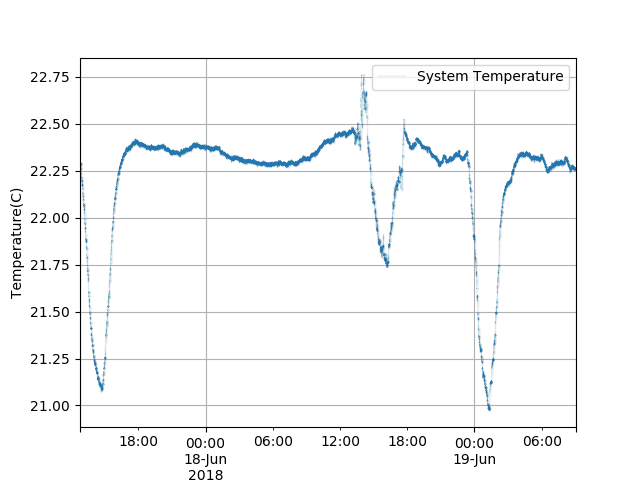

In [16]:
from numpy import genfromtxt
import pandas as pd
my_data=genfromtxt('Rb_labtemperature.csv',delimiter=',')
data_cutoff=1470 # to cutoff bad data at the beginning
temperatures_in_C=np.array(my_data[data_cutoff:,1])
flattendedtimestamps_temp=np.array(my_data[data_cutoff:,0])/2**32
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps_temp]
samplerate='1S'
df_temperature=pd.DataFrame({'System Temperature': temperatures_in_C,
                },index=dates)

data_to_plot2=df_temperature.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['System Temperature'],alpha=0.5,lw=0.2,marker='.',markersize=0.02)
ax.set_ylabel('Temperature(C)')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


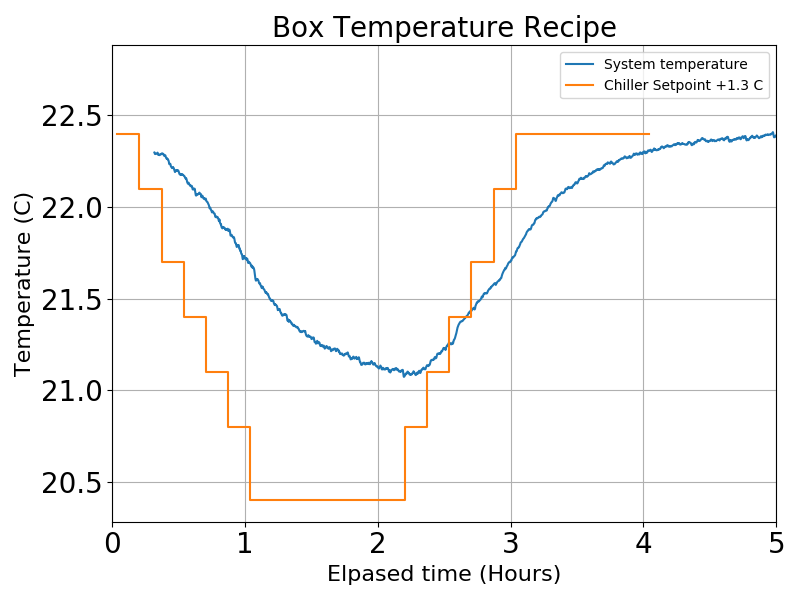

In [39]:
cooking_starttime=dt.datetime(2018,6,17,12,30)
cooking_start_timestamp=time.mktime(cooking_starttime.timetuple())
timetable=np.linspace(cooking_start_timestamp,cooking_start_timestamp+240*60,25)
cookingtable=np.array([21.1, 20.8, 20.4, 20.1, 19.8, 19.5, 19.1, 19.1, 19.1, 19.1, 19.1, 19.1, 19.1, 19.5, 19.8, 20.1, 20.4, 20.8, 21.1,21.1, 21.1, 21.1, 21.1, 21.1, 21.1])


fig, ax=plt.subplots()
fig.set_size_inches(8,6)
offset_chiller=1.3
ax.plot((flattendedtimestamps_temp-experiment_start_time)/3600,temperatures_in_C,label='System temperature')
ax.step((timetable-experiment_start_time)/3600,cookingtable+offset_chiller,where='post',label='Chiller Setpoint +{} C'.format(offset_chiller))
ax.grid()
ax.set_xlabel('Elpased time (Hours)',fontsize=16)
ax.set_ylabel('Temperature (C)',fontsize=16)
ax.set_title('Box Temperature Recipe',fontsize=20)
ax.legend()
ax.set_xlim(0,5)
ax.tick_params(labelsize=20)
plt.tight_layout()
savefig=False
if savefig:
    plt.savefig("20180618_Closedloop_Temperature Recipe.png")

# Camera data analysis

<IPython.core.display.Javascript object>


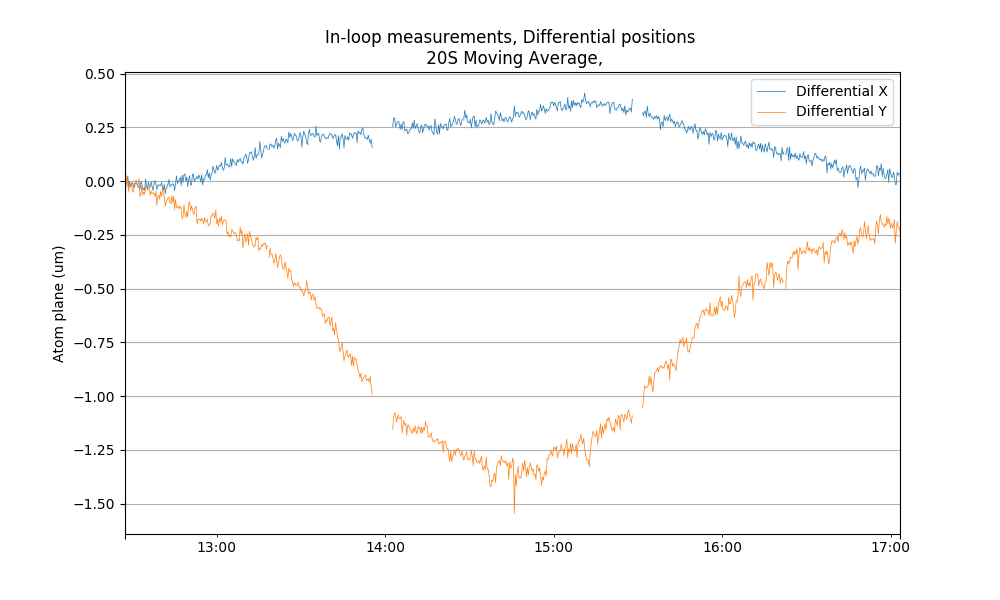

<IPython.core.display.Javascript object>


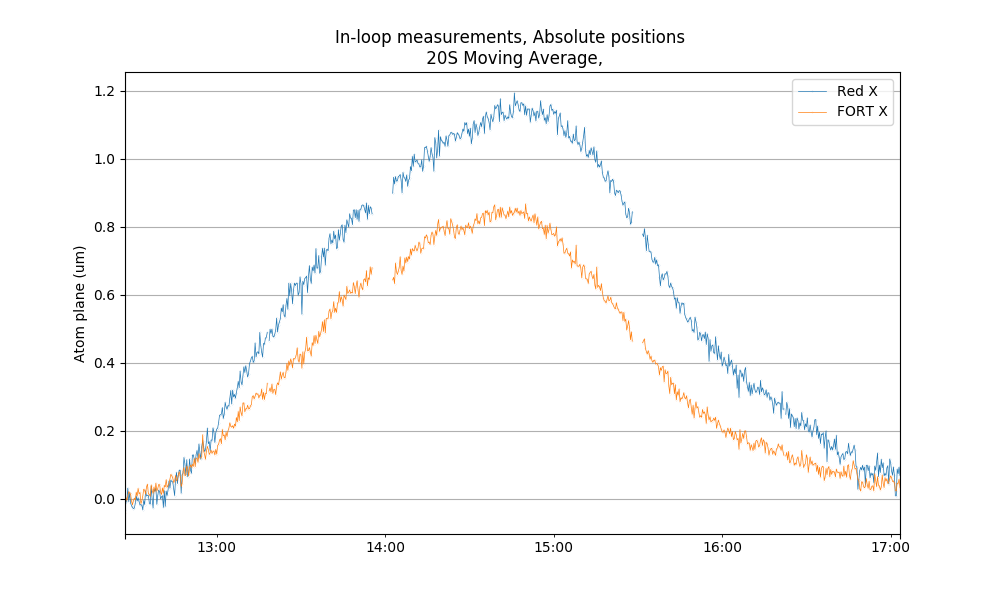

<IPython.core.display.Javascript object>


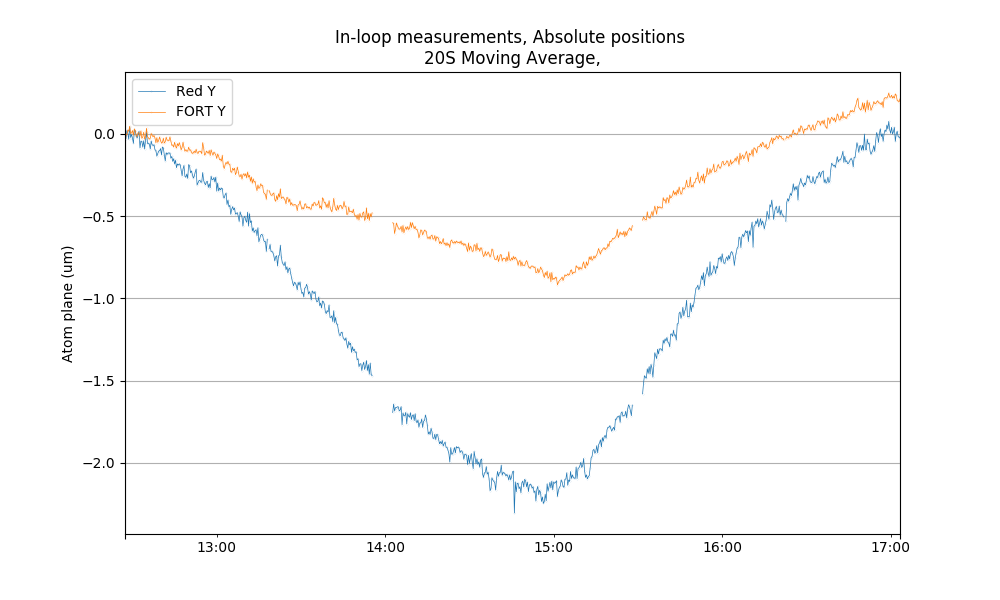

<IPython.core.display.Javascript object>


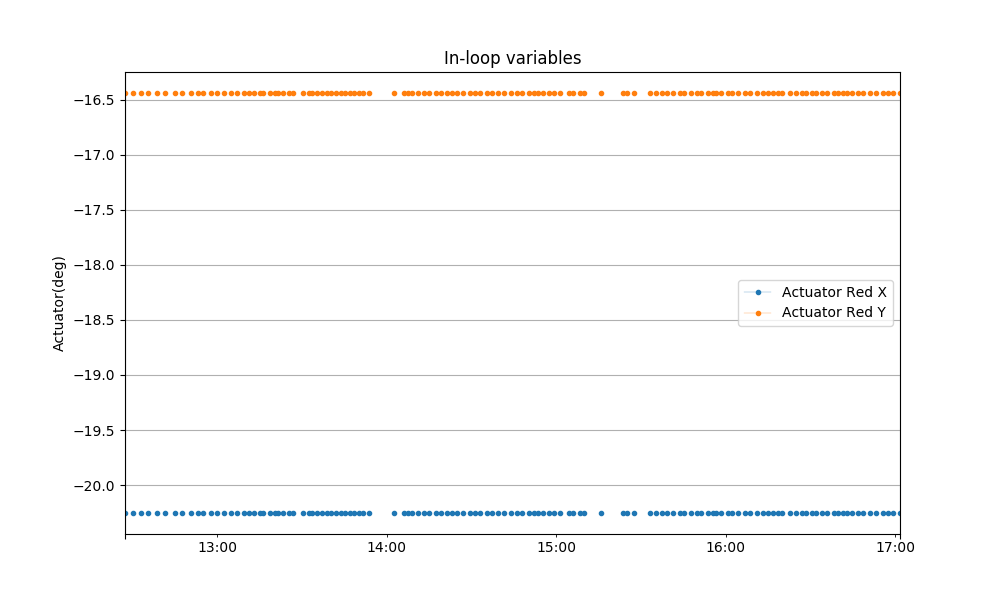

In [21]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))

dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]
dates_iterations=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

offset_Red_X=np.mean(flatteneddata0[0:100])#np.median(flatteneddata0)
offset_Red_Y=np.mean(flatteneddata1[0:100])#np.median(flatteneddata1)
offset_FORT_X=np.mean(flatteneddata2[0:100])#np.median(flatteneddata2)
offset_FORT_Y=np.mean(flatteneddata3[0:100])#np.median(flatteneddata3)

offsetX0=np.mean((flatteneddata0-flatteneddata2)[0:100])
offsetX_median=np.median(flatteneddata0-flatteneddata2)
offsetY0=np.mean((flatteneddata1-flatteneddata3)[0:100])
offsetY_median=np.median(flatteneddata1-flatteneddata3)
df_camera=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX0,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY0,
                 'Red X': flatteneddata0-offset_Red_X,
                 'Red Y': flatteneddata1-offset_Red_Y,
                 'FORT X': flatteneddata2-offset_FORT_X,
                 'FORT Y': flatteneddata3-offset_FORT_Y,
                },index=dates)

df_actuators=pd.DataFrame({
                 'Actuator Red X':np.array(data['Red_X']),
                 'Actuator Red Y':np.array(data['Red_Y'])
                },index=dates_iterations)

samplerate='20S'
## 
data_to_plot2=df_camera.resample(samplerate).mean()
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Differential X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['Differential Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Differential positions \n {} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

##
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Red X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['FORT X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Absolute positions \n {} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Red Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['FORT Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Absolute positions \n{} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

data_to_plot3=df_actuators.resample(samplerate).mean()

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot3.plot(y=['Actuator Red X'],alpha=1,lw=0.2,marker='.',ax=ax)
data_to_plot3.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.',ax=ax)
ax.set_title('In-loop variables'.format(samplerate))
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()


<IPython.core.display.Javascript object>


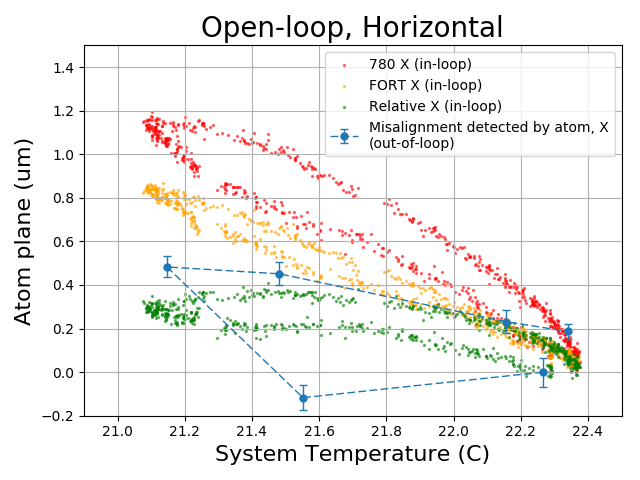

<IPython.core.display.Javascript object>


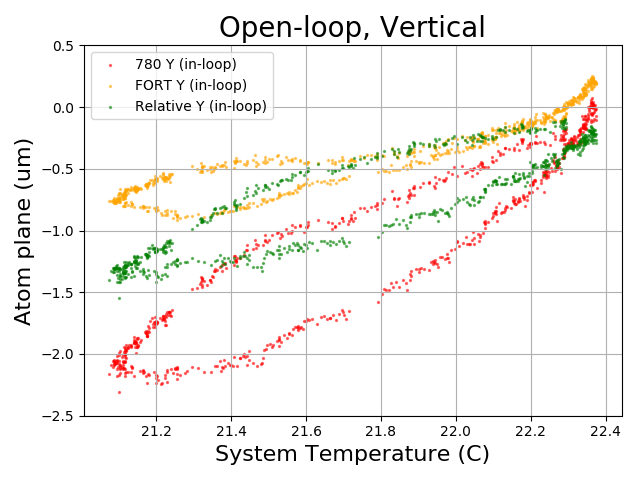

In [22]:
frames=[df_temperature,df,df_displacement,df_camera]
result=pd.concat(frames)
samplerate='20S'
data_to_plot3=result.resample(samplerate).mean()
fig, ax = plt.subplots()
data_to_plot3.plot(kind='scatter',y='Red X',x='System Temperature',alpha=0.5,s=2,color='r',label='780 X (in-loop)',ax=ax)
data_to_plot3.plot(kind='scatter',y='FORT X',x='System Temperature',alpha=0.5,s=2,color='orange',ax=ax,label='FORT X (in-loop)')
data_to_plot3.plot(kind='scatter',y='Differential X',x='System Temperature',alpha=0.5,s=2,color='green',ax=ax,label='Relative X (in-loop)')
data_to_plot3.dropna().plot(y="Displacment from the bias point",yerr='Max_error',x='System Temperature',capsize=3,lw=1,marker='o',alpha=1,linestyle='--',markersize=5,ax=ax,label='Misalignment detected by atom, X\n(out-of-loop)')
#data_to_plot3.plot(y="Displacment from the bias point",yerr='Max_error',x='System Temperature',capsize=3,lw=1,marker='o',alpha=1,linestyle='--',markersize=5,ax=ax,label='Misalignment detected by atom, X\n(out-of-loop)')
#data_to_plot3.plot(y="Displacment from the bias point",x='System Temperature',capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'],ax=ax)
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('System Temperature (C)',fontsize=16)
ax.grid()
ax.legend()
ax.set_xlim(20.9,22.5)
ax.set_ylim(-0.2,1.5)
ax.set_title('Open-loop, Horizontal',fontsize=20)
plt.tight_layout()
plt.savefig("20180617_Openloop_Xcurve.png")

fig, ax2 = plt.subplots()
data_to_plot3.plot(kind='scatter',y='Red Y',x='System Temperature',alpha=0.5,s=2,color='r',label='780 Y (in-loop)',ax=ax2)
data_to_plot3.plot(kind='scatter',y='FORT Y',x='System Temperature',alpha=0.5,s=2, color='orange',ax=ax2,label='FORT Y (in-loop)')
data_to_plot3.plot(kind='scatter',y='Differential Y',x='System Temperature',alpha=0.5,s=2, color='green',ax=ax2,label='Relative Y (in-loop)')
ax2.set_ylabel('Atom plane (um)',fontsize=16)
ax2.set_xlabel('System Temperature (C)',fontsize=16)
ax2.grid()
ax2.legend()
ax.set_xlim(20.9,22.5)
ax2.set_ylim(-2.5,0.5)
ax2.set_title('Open-loop, Vertical',fontsize=20)
plt.tight_layout()
plt.savefig("20180617_Openloop_Ycurve.png")

<IPython.core.display.Javascript object>


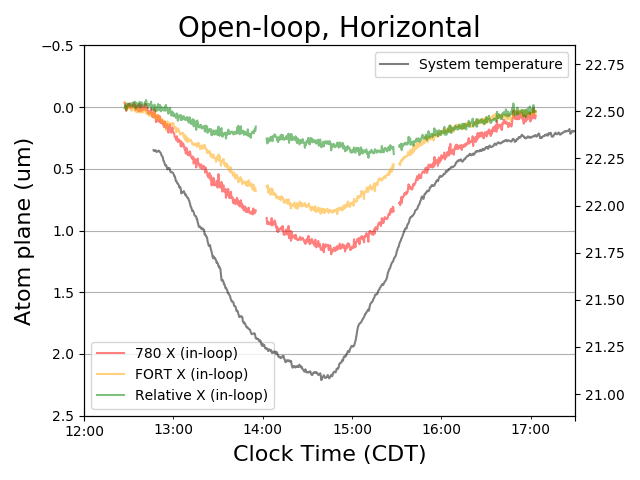

<IPython.core.display.Javascript object>


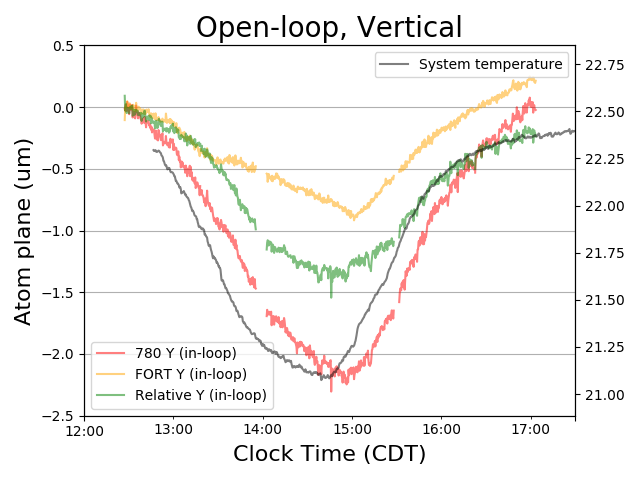

In [47]:
fig, ax = plt.subplots()
data_to_plot3.plot(y='Red X',alpha=0.5,color='r',label='780 X (in-loop)',ax=ax)
data_to_plot3.plot(y='FORT X',alpha=0.5,color='orange',ax=ax,label='FORT X (in-loop)')
data_to_plot3.plot(y='Differential X',alpha=0.5,color='green',ax=ax,label='Relative X (in-loop)')
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('Clock Time (CDT)',fontsize=16)
ax2=ax.twinx()
data_to_plot3.plot(y='System Temperature',alpha=0.5,color='black',label='System temperature',ax=ax2)
#'System Temperature'
ax.grid()
ax.legend()
ax.set_xlim(dt.datetime(2018,6,17,12,0),dt.datetime(2018,6,17,17,30))
ax.set_ylim(2.5,-0.5)
ax.set_title('Open-loop, Horizontal',fontsize=20)
plt.tight_layout()

fig, ax = plt.subplots()
data_to_plot3.plot(y='Red Y',alpha=0.5,color='r',label='780 Y (in-loop)',ax=ax)
data_to_plot3.plot(y='FORT Y',alpha=0.5,color='orange',ax=ax,label='FORT Y (in-loop)')
data_to_plot3.plot(y='Differential Y',alpha=0.5,color='green',ax=ax,label='Relative Y (in-loop)')
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('Clock Time (CDT)',fontsize=16)
ax2=ax.twinx()
data_to_plot3.plot(y='System Temperature',alpha=0.5,color='black',label='System temperature',ax=ax2)

ax.grid()
ax.legend()
ax.set_xlim(dt.datetime(2018,6,17,12,0),dt.datetime(2018,6,17,17,30))
ax.set_ylim(-2.5,0.5,)
ax.set_title('Open-loop, Vertical',fontsize=20)
plt.tight_layout()

In [137]:
data_to_plot3.dropna()

,Differential X,Differential Y,Displacment from the bias point,FORT X,FORT Y,Max_error,Min_error,Red X,Red Y,System Temperature,beam displacment
2018-06-17 13:18:40,0.147750,-0.353719,-0.117116,0.317430,-0.344659,0.058805,0.060822,0.465180,-0.698378,21.878363,2.139052
2018-06-17 14:02:40,0.254665,-1.153724,0.482910,0.643503,-0.539485,0.048399,0.049757,0.898168,-1.693209,21.238463,1.539026
2018-06-17 14:46:00,0.350608,-1.543844,0.451183,0.842089,-0.760588,0.052384,0.053978,1.192697,-2.304433,21.100977,1.570752
2018-06-17 15:41:20,0.311412,-0.923355,0.231739,0.309418,-0.370895,0.051320,0.052849,0.620830,-1.294250,21.952385,1.790197
2018-06-17 16:22:40,0.122306,-0.500602,0.186594,0.126041,-0.030645,0.036378,0.037140,0.248347,-0.531246,22.279874,1.835342


<IPython.core.display.Javascript object>


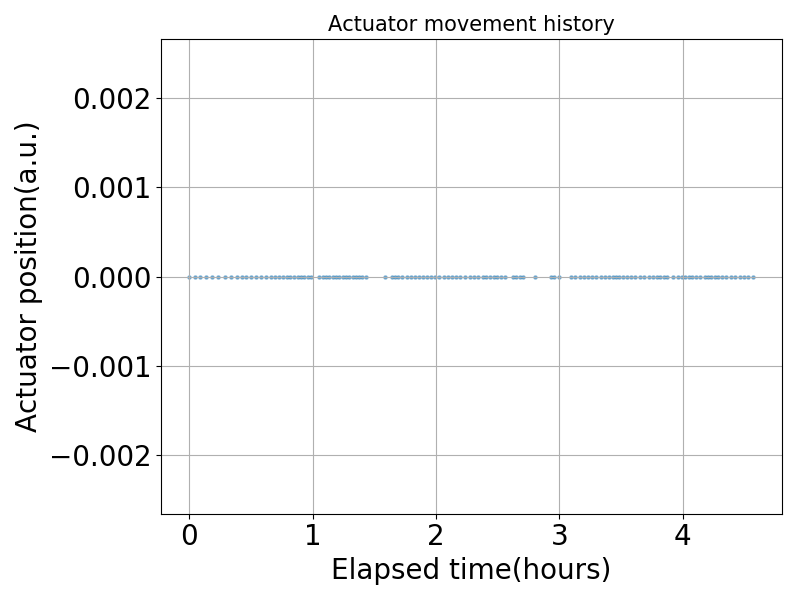

<IPython.core.display.Javascript object>


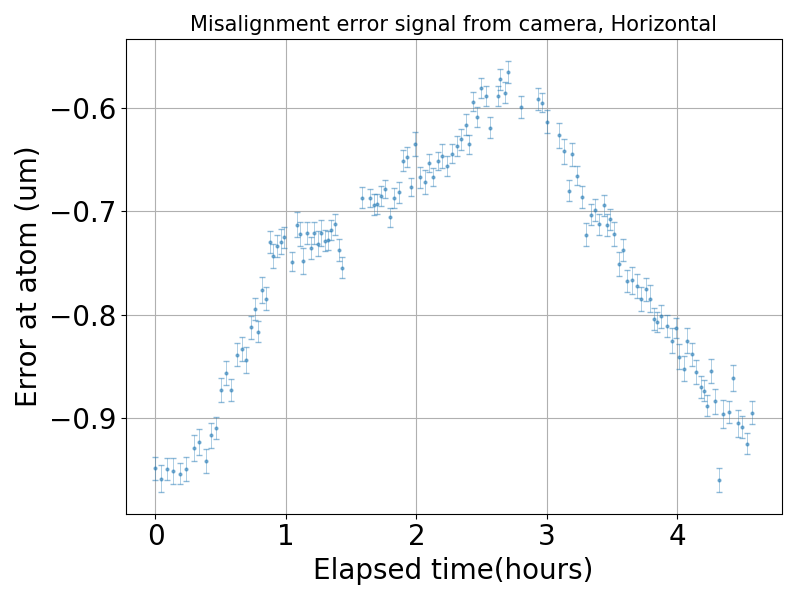

In [18]:
## Actuator Plot
savefig=False
actuator_x=np.array(data['Red_X'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, X
camera_error_x=[]
camera_error_sigma_x=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Horizontal',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


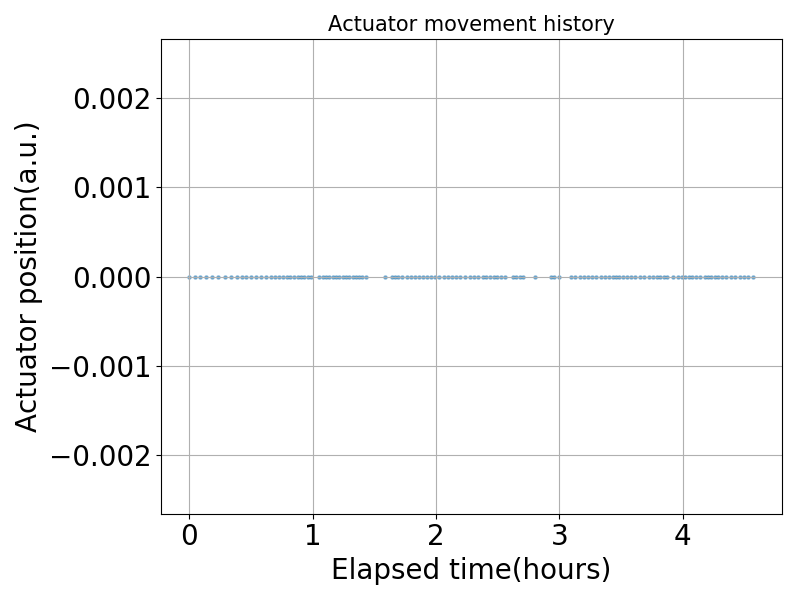

<IPython.core.display.Javascript object>


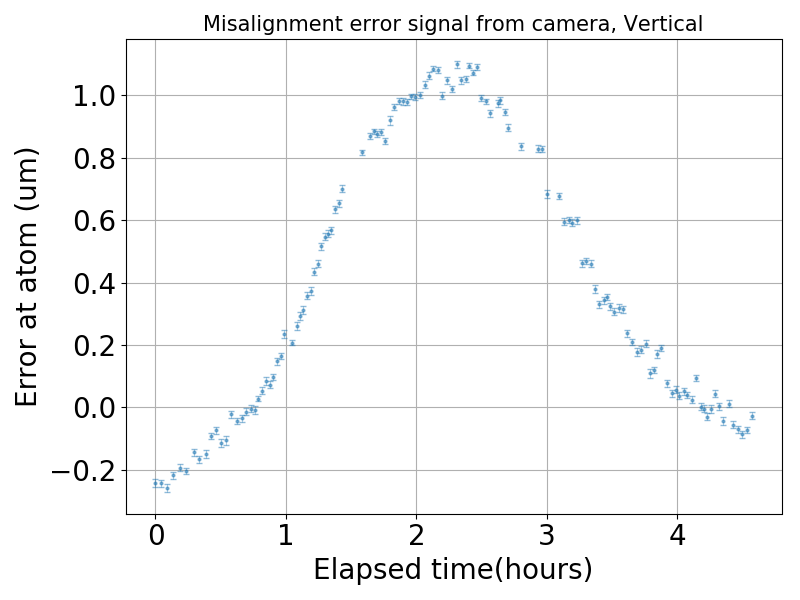

In [19]:
## Actuator Plot
savefig=False
actuator_y=np.array(data['Red_Y'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_y-actuator_y[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, Y
camera_error_y=[]
camera_error_sigma_y=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_y.append(data[keylist[4]][i]['error_y']/calibration_factor)
        camera_error_sigma_y.append(data[keylist[4]][i]['sigma_y']/math.sqrt(samples))
    except:
        print i
        camera_error_y.append(np.nan)
        camera_error_sigma_y.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_y,yerr=camera_error_sigma_y,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Vertical',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

# Figuring out the dead region

<IPython.core.display.Javascript object>


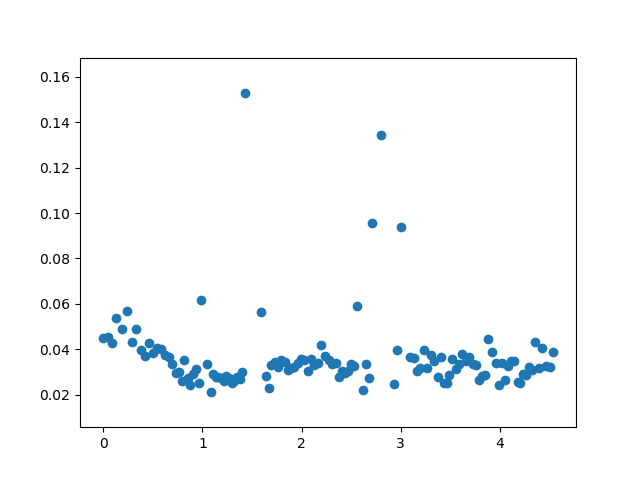

In [21]:
fig, ax= plt.subplots()
sorted_times=np.sort(elapsed_time_in_hours)
dead_times=sorted_times[1:]-sorted_times[0:-1]
ax.scatter(sorted_times[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(sorted_times[0:-1][i],dead_times[i])
        dead_T.append(sorted_times[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


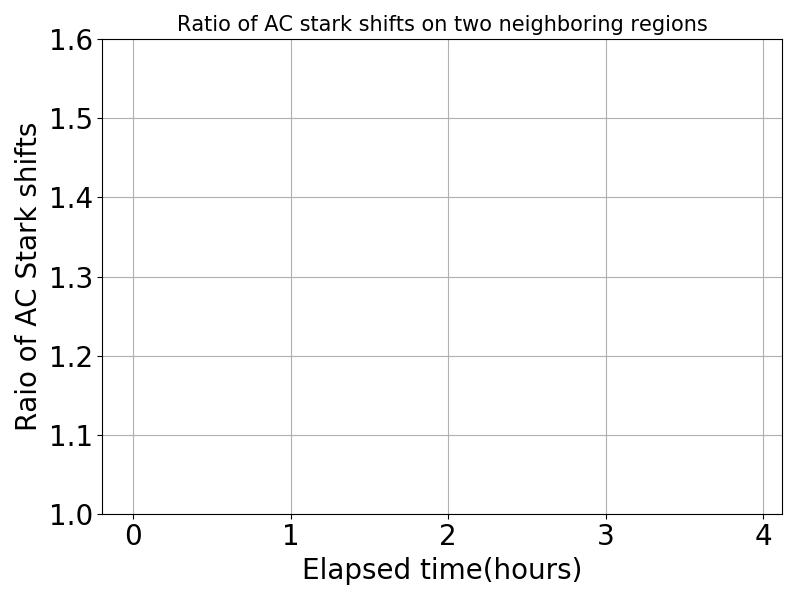

In [23]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.3-0.3,1.3+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Allan deviation

In [51]:
from IPython.display import display, clear_output
name='20180615_openloop_boxtesting'
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,10)+range(10003,100003,10)#+range(80004,100004,50)+range(100005,1000005,500)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    clear_output()
    display('Tau: '+str(tau))
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass
    
try:
    np.save(name+'_taulist',tau_list)
    np.save(name+'_X',np.sqrt(0.5*np.array(var_list['Differential X'])))
    np.save(name+'_Y',np.sqrt(0.5*np.array(var_list['Differential Y'])))
except:
    pass

'Tau: 99993'

<IPython.core.display.Javascript object>


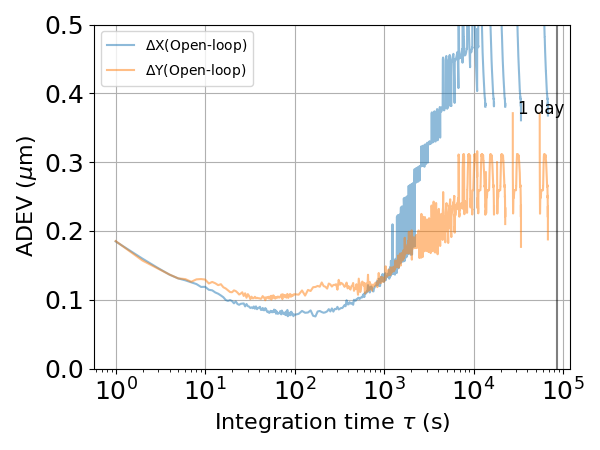

In [52]:
tau_list=np.load(name+'_taulist.npy')
Xlist=np.load(name+'_X.npy')
Ylist=np.load(name+'_Y.npy')

# tau_list2=np.load('20180525_closedloop_taulist.npy')
# Xlist2=np.load('20180525_closedloop_X.npy')
# Ylist2=np.load('20180525_closedloop_Y.npy')


savefig=False
fig, ax = plt.subplots()
fig.set_size_inches(6,4.5)
ax.semilogx(tau_list, Xlist,label=r'$\Delta$X(Open-loop)',alpha=0.5)
ax.semilogx(tau_list, Ylist,label=r'$\Delta$Y(Open-loop)',alpha=0.5)
# ax.semilogx(tau_list2, Xlist2,label=r'$\Delta$X(Closed-loop)',alpha=0.5)
# ax.semilogx(tau_list2, Ylist2,label=r'$\Delta$Y(Closed-loop)',alpha=0.5)
ax.tick_params(labelsize=18)
ax.legend()
plt.axvline(x=86400,color='black',alpha=0.5)
#ax.set_xlim(1,)
#ax.set_title('Allan Deviation (Open-loop vs Closed-loop)',size=)
ax.set_xlabel(r'Integration time $\tau$ (s)',size=16)
ax.set_ylabel(r'ADEV ($\mu$m)',size=16)
#ax.text(10**0,0.3,'Feedback uses last 100 measurements(~ 30 sec)\n from each iteration.\nFeedback cycle time typically ~ 2 min, when activated')
ax.text(10**4.5,0.37,'1 day',size=12)
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.0,0.5)
ax.grid()
plt.tight_layout()
filename='20180522_AllanDeviation_comparison'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')
